In [1]:
%matplotlib inline

In [2]:
# Set up search criteria
GDA94_bounds = (119, -28.25, 119.75, -27.5) # Bounding box in GDA94 coordinates
keywords = 'point, gravity, point located data, ground digital data, geophysical survey' # Comma-separated list of keywords
grid_variable_name = 'bouguer'

In [3]:
import os
import netCDF4
import numpy as np
from geophys_utils import NetCDFPointUtils
import matplotlib.pyplot as plt
from geophys_utils import array2file
from osgeo import gdal
from geophys_utils import CSWUtils
import os
import re
from netCDF4 import Dataset
from pprint import pprint
import requests
import math
from scipy.interpolate import griddata
from skimage import exposure
from geophys_utils import transform_coords, get_utm_wkt, get_spatial_ref_from_wkt

In [4]:
def get_netcdf_datasets(keywords, 
                        bounding_box=None, 
                        start_date_string=None, 
                        end_date_string=None, 
                        csw_url=None,
                        ):
    '''
    Find all datasets of interest and return a list of NetCDF file paths or OPeNDAP web service endpoints
    '''    
    csw_url = csw_url or 'https://ecat.ga.gov.au/geonetwork/srv/eng/csw'
    #create a csw_utils object and populate the parameters with search parameters
    # N.B: "verify" parameter requires hack to geophys_utils.csw_utils, owslib.csw & owslib.utils 
    try:
        cswu = CSWUtils(csw_url) 
    except:
        cswu = CSWUtils(csw_url, verify=False) 
        
    if start_date_string:
        start_datetime = date_string2datetime(start_date_string)
        assert start_datetime is not None, 'Invalid date string for start date'
    else:
        start_datetime = None
        
    if end_date_string:
        end_datetime = date_string2datetime(end_date_string)
        assert end_datetime is not None, 'Invalid date string for end date'
    else:
        end_datetime = None
        
    print('Querying CSW')
    record_list = [record for record in cswu.query_csw(keyword_list=keywords,
                                      #anytext_list=allwords,
                                      #titleword_list=titlewords,
                                      bounding_box=bounding_box,
                                      start_datetime=start_datetime,
                                      stop_datetime=end_datetime,
                                      #max_total_records=2000
                                      )
              ]
    print('{} matching dataset records found from CSW'.format(len(record_list)))
    
    netcdf_list = [distribution['url']
            for distribution in cswu.get_netcdf_urls(record_list)
            ]

    print('{} NetCDF distributions found'.format(len(netcdf_list)))
    
    return netcdf_list

In [5]:
def dataset_value_generator(variable_name_list,
                            dataset_list, 
                            bounding_box, 
                            coordinate_wkt,
                            min_points=None,
                            max_points=None
                            ):
    '''
    Generator yielding coordinates and values of the specified variable for all points from the supplied dataset list 
    which fall within bounds
    '''    
    line_dataset_count = 0
    for dataset in dataset_list:
        line_data = {}
        try:
            nc_dataset = Dataset(dataset)
            netcdf_point_utils = NetCDFPointUtils(nc_dataset) 
            
            #print netcdf_point_utils.__dict__
            #print(nc_dataset.variables.keys())
            
            #print('Computing spatial mask')
            spatial_mask = netcdf_point_utils.get_spatial_mask(bounding_box)
            
            point_count = np.count_nonzero(spatial_mask)

            if not point_count:
                #print('Skipping dataset with no points in bounding box')
                continue
            
            # Enforce min/max point counts
            if min_points and point_count < min_points:
                print('Skipping dataset with < {} points'.format(min_points))
                continue
            if max_points and point_count > max_points:
                print('Skipping dataset with > {} points'.format(max_points))
                continue
                
            print('{}/{} points found in bounding box for {}'.format(point_count, netcdf_point_utils.point_count, dataset))
                        
            dataset_value_dict = {'coordinates': netcdf_point_utils.xycoords[spatial_mask]}
            
            # Read all variable attributes and values
            for variable_name in variable_name_list:
                variable = nc_dataset.variables[variable_name]
                if (variable.dimensions[0] != 'point'): # Variable is NOT of point dimension - must be lookup
                    dataset_value_dict[variable_name] = netcdf_point_utils.expand_lookup_variable(lookup_variable_name=variable_name, 
                                                                                                  mask=spatial_mask)                     
                else: # 'point' is in variable.dimensions - "normal" variable                
                    dataset_value_dict[variable_name] = variable[spatial_mask]
            
            yield dataset, dataset_value_dict
    
        except Exception as e:
            print('Unable to read point dataset {}: {}'.format(dataset, e))
        finally:
            del netcdf_point_utils


In [6]:
def grid_points(coordinates,
                coordinate_wkt,
                values,
                grid_wkt, 
                grid_bounds,
                grid_resolution, 
                resampling_method='linear', 
                point_step=1):
    '''
    Return interpolated grid from supplied coordinates and points
    '''
    
    # Determine spatial grid bounds rounded out to nearest GRID_RESOLUTION multiple
    pixel_centre_bounds = (round(math.floor(grid_bounds[0] / grid_resolution) * grid_resolution, 6),
                   round(math.floor(grid_bounds[1] / grid_resolution) * grid_resolution, 6),
                   round(math.floor(grid_bounds[2] / grid_resolution - 1.0) * grid_resolution + grid_resolution, 6),
                   round(math.floor(grid_bounds[3] / grid_resolution - 1.0) * grid_resolution + grid_resolution, 6)
                   )
    
    print("Reprojecting coordinates")
    grid_coordinates = np.array(transform_coords(coordinates, coordinate_wkt, grid_wkt))

    print("Computing spatial mask")
    spatial_subset_mask = np.logical_and(np.logical_and((grid_bounds[0] <= grid_coordinates[:,0]), 
                                                        (grid_coordinates[:,0] <= grid_bounds[2])), 
                                         np.logical_and((grid_bounds[1] <= grid_coordinates[:,1]), 
                                                        (grid_coordinates[:,1] <= grid_bounds[3]))
                                        )    
    # Create grids of Y and X values. Note YX ordering and inverted Y for image
    # Note GRID_RESOLUTION/2.0 fudge to avoid truncation due to rounding error
    print("Generating grid coordinates")
    grid_y, grid_x = np.mgrid[pixel_centre_bounds[3]:pixel_centre_bounds[1]-grid_resolution/2.0:-grid_resolution, 
                              pixel_centre_bounds[0]:pixel_centre_bounds[2]+grid_resolution/2.0:grid_resolution]

    # Skip points to reduce memory requirements
    print("Generating spatial subset mask")
    point_subset_mask = np.zeros(shape=values.shape, dtype=bool)
    point_subset_mask[0:-1:point_step] = True
    point_subset_mask = np.logical_and(spatial_subset_mask, point_subset_mask)
    assert point_subset_mask.any(), 'No points found within grid bounds %s' % grid_bounds
    
    grid_coordinates = grid_coordinates[point_subset_mask]

    # Interpolate required values to the grid - Note yx ordering for image
    print("Interpolating {} points".format(grid_coordinates.shape[0]))
    grid_array = griddata(grid_coordinates[:,::-1],
                          values[point_subset_mask],
                          (grid_y, grid_x), 
                          method=resampling_method
                          )

    print("Interpolation complete")
    #  crs:GeoTransform = "109.1002342895272 0.00833333 0 -9.354948067227777 0 -0.00833333 "
    geotransform = [pixel_centre_bounds[0]-grid_resolution/2.0,
                    grid_resolution,
                    0,
                    pixel_centre_bounds[3]+grid_resolution/2.0,
                    0,
                    -grid_resolution
                    ] 

    return grid_array, grid_wkt, geotransform


In [7]:
# Find all NetCDF paths using CSW
netcdf_list = sorted(get_netcdf_datasets(keywords, 
                                         bounding_box=GDA94_bounds))
print('\n'.join(netcdf_list))

Querying CSW
23 matching dataset records found from CSW
23 NetCDF distributions found
http://dapds00.nci.org.au/thredds/dodsC/rr2/ground_gravity/Commonwealth/P195099/points/P195099_GNDGRAV/P195099_GNDGRAV.nc
http://dapds00.nci.org.au/thredds/dodsC/rr2/ground_gravity/Commonwealth/P196091/points/P196091_GNDGRAV/P196091_GNDGRAV.nc
http://dapds00.nci.org.au/thredds/dodsC/rr2/ground_gravity/Commonwealth/P196491/points/P196491_GNDGRAV/P196491_GNDGRAV.nc
http://dapds00.nci.org.au/thredds/dodsC/rr2/ground_gravity/Commonwealth/P196500/points/P196500_GNDGRAV/P196500_GNDGRAV.nc
http://dapds00.nci.org.au/thredds/dodsC/rr2/ground_gravity/Commonwealth/P196792/points/P196792_GNDGRAV/P196792_GNDGRAV.nc
http://dapds00.nci.org.au/thredds/dodsC/rr2/ground_gravity/Commonwealth/P196793/points/P196793_GNDGRAV/P196793_GNDGRAV.nc
http://dapds00.nci.org.au/thredds/dodsC/rr2/ground_gravity/Commonwealth/P198090/points/P198090_GNDGRAV/P198090_GNDGRAV.nc
http://dapds00.nci.org.au/thredds/dodsC/rr2/ground_gravity/C

In [8]:
# Calculate extra spatial information about area of interest
GDA94_wkt = get_spatial_ref_from_wkt('EPSG:4283').ExportToWkt()

GDA94_centre_coords = [(GDA94_bounds[dim_index] + GDA94_bounds[dim_index+2]) / 2.0 for dim_index in range(2)]

utm_wkt = get_utm_wkt(GDA94_centre_coords, GDA94_wkt)

reprojected_bounding_box = np.array(transform_coords(((GDA94_bounds[0], GDA94_bounds[1]), 
                                                      (GDA94_bounds[2], GDA94_bounds[1]), 
                                                      (GDA94_bounds[2], GDA94_bounds[3]), 
                                                      (GDA94_bounds[0], GDA94_bounds[3])
                                                      ), 
                                                      GDA94_wkt, utm_wkt))
utm_bounds = [min(reprojected_bounding_box[:,0]), 
              min(reprojected_bounding_box[:,1]), 
              max(reprojected_bounding_box[:,0]), 
              max(reprojected_bounding_box[:,1])]


In [9]:
# Retrieve all points in bounding box from NetCDF files in UTM projection
# N.B: This may take some time depending on the size of the bounds and the number and size of line datasets
# Lines will be filtered to exclude tielines by using "flight_lines_only=True"
dataset_values = {dataset: dataset_value_dict
                  for dataset, dataset_value_dict in dataset_value_generator([grid_variable_name, 'gridflag'],
                                                              netcdf_list, 
                                                              GDA94_bounds, 
                                                              utm_wkt,
                                                              )
                 }

#print(dataset_values)

3/62 points found in bounding box for http://dapds00.nci.org.au/thredds/dodsC/rr2/ground_gravity/Commonwealth/P196792/points/P196792_GNDGRAV/P196792_GNDGRAV.nc


C:\Users\Alex\Anaconda3\lib\site-packages\geophys_utils\_netcdf_point_utils.py:662: UserWarning: WARNING: _FillValue not used since it
cannot be safely cast to variable data type
  result_array = lookup_variable[:][indexing_variable[start_index:end_index][subset_mask]] # Need to index numpy array, not netCDF variable


41/4457 points found in bounding box for http://dapds00.nci.org.au/thredds/dodsC/rr2/ground_gravity/WA/P197100/points/P197100_GNDGRAV/P197100_GNDGRAV.nc
5/425 points found in bounding box for http://dapds00.nci.org.au/thredds/dodsC/rr2/ground_gravity/WA/P197102/points/P197102_GNDGRAV/P197102_GNDGRAV.nc
4/122 points found in bounding box for http://dapds00.nci.org.au/thredds/dodsC/rr2/ground_gravity/WA/P197103/points/P197103_GNDGRAV/P197103_GNDGRAV.nc
82/90 points found in bounding box for http://dapds00.nci.org.au/thredds/dodsC/rr2/ground_gravity/WA/P200287/points/P200287_GNDGRAV/P200287_GNDGRAV.nc
998/5760 points found in bounding box for http://dapds00.nci.org.au/thredds/dodsC/rr2/ground_gravity/WA/P201063/points/P201063_GNDGRAV/P201063_GNDGRAV.nc
193/1742 points found in bounding box for http://dapds00.nci.org.au/thredds/dodsC/rr2/ground_gravity/WA/P201065/points/P201065_GNDGRAV/P201065_GNDGRAV.nc


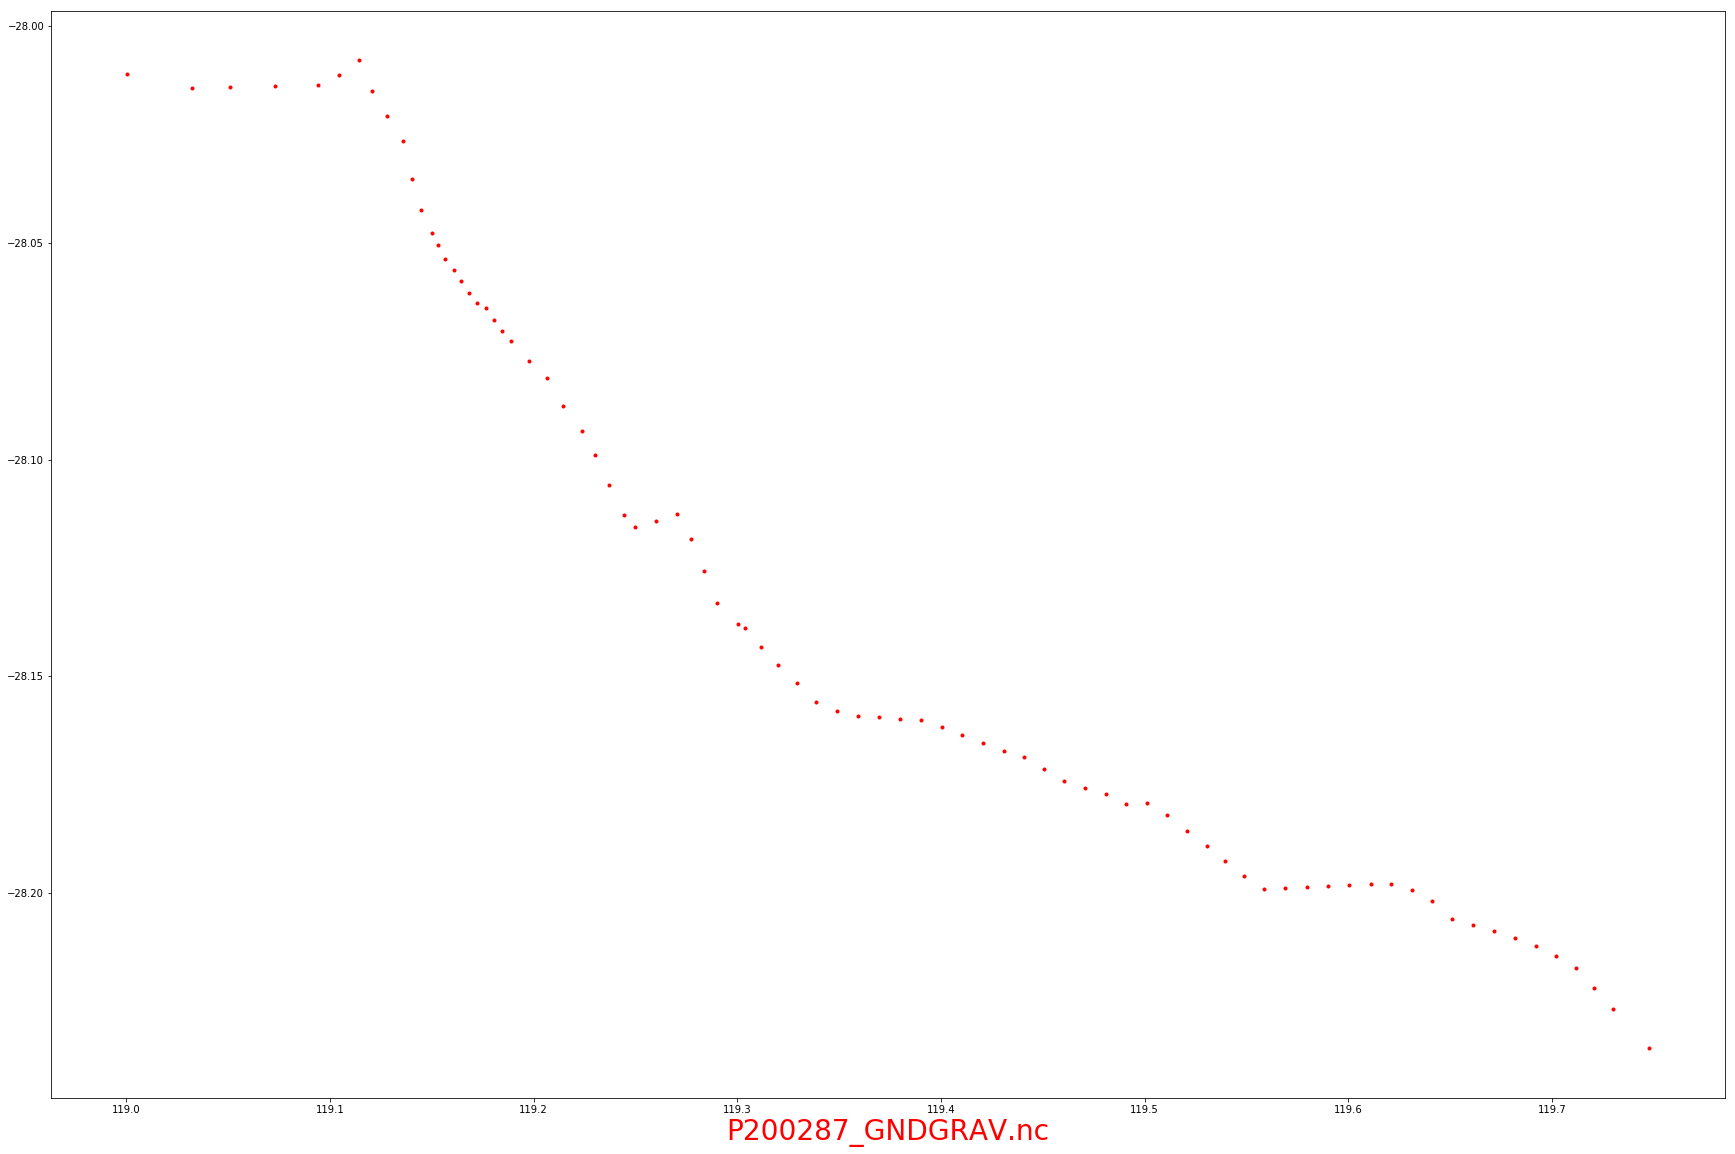

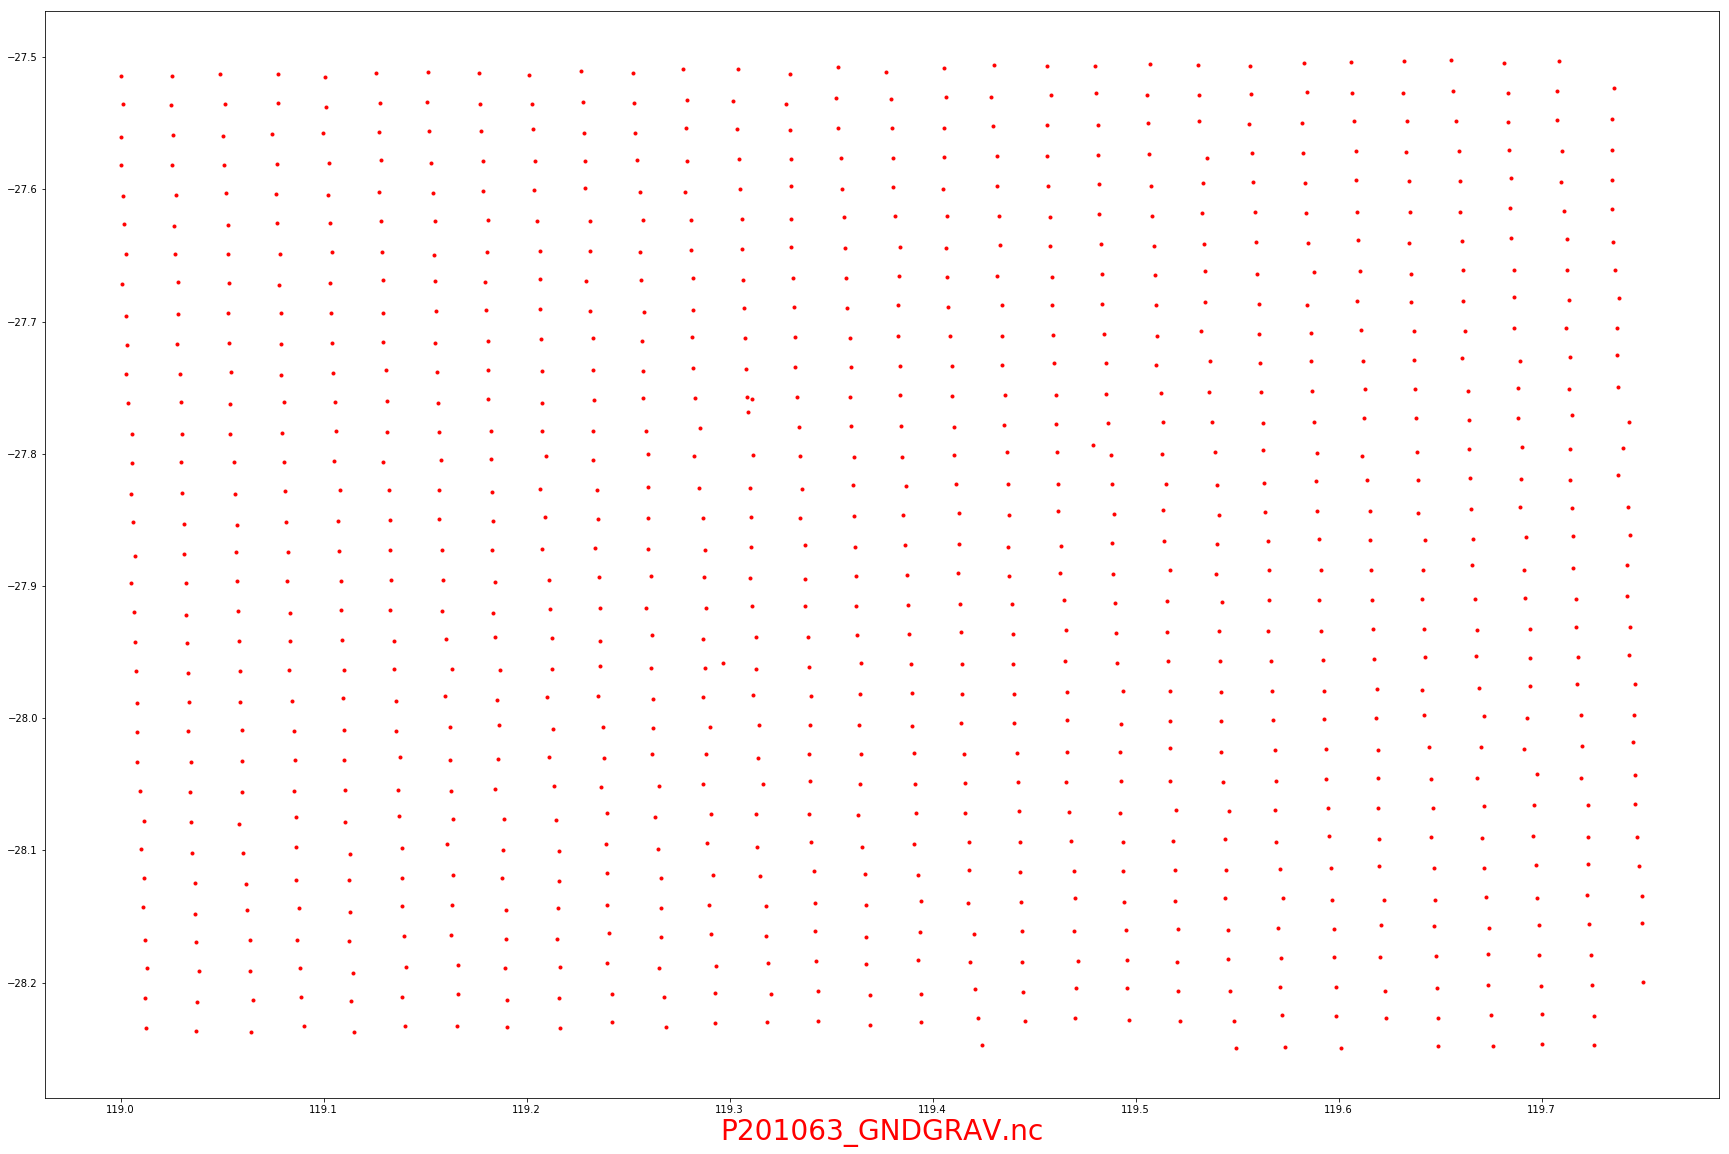

In [10]:
# Plot filtered points for each dataset
# Only show points where gridflag == 'Station used in the production of GA grids.'
for dataset in sorted(dataset_values.keys()):
    #print(dataset)
    #print(len(dataset_values[dataset]['coordinates']))
    #print(len(dataset_values[dataset]['gridflag'] == 'Station used in the production of GA grids.'))
    coordinates = dataset_values[dataset]['coordinates'][dataset_values[dataset]['gridflag'] == 'Station used in the production of GA grids.']
    if len(coordinates):
        plt.figure(figsize=(30,20))
        plt.xlabel(os.path.basename(dataset), fontsize=28, color='red')
        plt.plot(coordinates[:,0], coordinates[:,1], 'r.')

In [11]:
# Gather all filtered points in bounding box in UTM projection
# Only use points where gridflag == 'Station used in the production of GA grids.'
all_coordinates = np.concatenate([dataset_values[dataset]['coordinates'][dataset_values[dataset]['gridflag'] == 'Station used in the production of GA grids.']
                                  for dataset in sorted(dataset_values.keys())])
all_values = np.concatenate([dataset_values[dataset][grid_variable_name][dataset_values[dataset]['gridflag'] == 'Station used in the production of GA grids.']
                                  for dataset in sorted(dataset_values.keys())])
print(all_coordinates)
print(all_values)

[[119.15028  -28.04769 ]
 [119.21439  -28.08754 ]
 [119.28988  -28.13297 ]
 ...
 [119.48135  -27.574202]
 [119.48145  -27.551672]
 [119.48031  -27.527407]]
[-683.5  -418.04 -514.13 ... -577.39 -555.51 -529.74]


In [12]:
# Determine grid resolution dynamically
grid_area = (utm_bounds[2] - utm_bounds[0]) * (utm_bounds[3] - utm_bounds[1]) # Area of bounding box in square metres
grid_resolution = math.sqrt(grid_area / len(all_coordinates)) # Determine square root of (points / square metre)
grid_resolution = math.pow(10.0, math.floor(math.log10(grid_resolution))) # Round pixel size down to nearest power of ten
print(grid_resolution)

1000.0


In [13]:
# Interpolate points to grid
interpolated_grid, wkt, geotransform = grid_points(coordinates=all_coordinates,
                                 coordinate_wkt=GDA94_wkt,
                                 values=all_values,
                                 grid_wkt=utm_wkt, 
                                 grid_bounds=utm_bounds,
                                 grid_resolution=grid_resolution, 
                                 resampling_method='linear', 
                                 point_step=1
                                 )

Reprojecting coordinates
Computing spatial mask
Generating grid coordinates
Generating spatial subset mask
Interpolating 1079 points
Interpolation complete


In [14]:
# Print some stats from the grid
print('Shape: ', interpolated_grid.shape)
print('Min:  ', np.nanmin(interpolated_grid))
print('Mean: ', np.nanmean(interpolated_grid))
print('Max:  ', np.nanmax(interpolated_grid))
print('geotransform: ', geotransform)
print('wkt: ', wkt)

Shape:  (85, 76)
Min:   -833.7607802920718
Mean:  -675.1701735469542
Max:   -236.71378226315915
geotransform:  [695500.0, 1000.0, 0, 6956500.0, 0, -1000.0]
wkt:  PROJCS["UTM Zone 50, Southern Hemisphere",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",117],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",10000000],UNIT["Meter",1]]


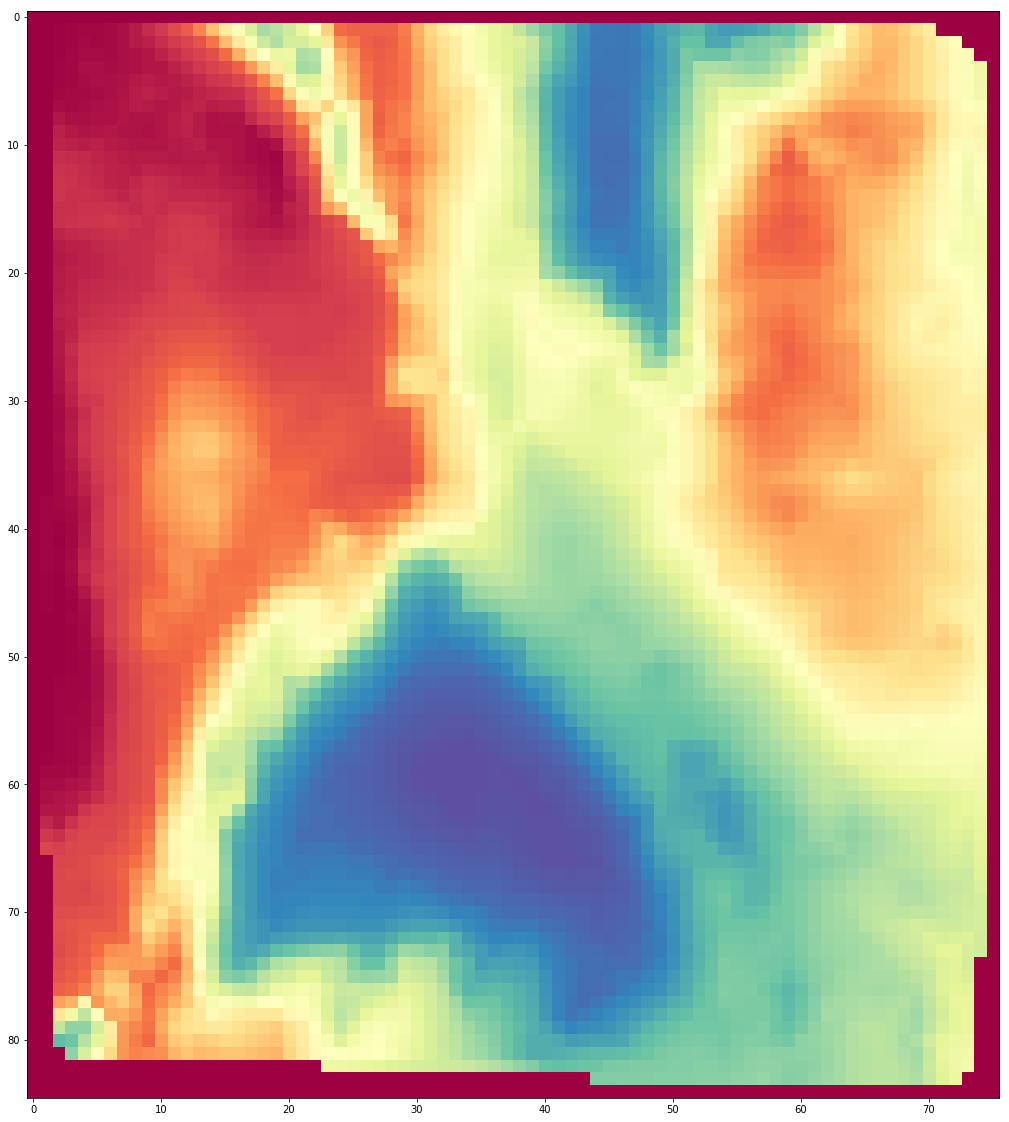

In [15]:
# Plot interpolated grid with histogram equalisation
# Substitute minimum value for NaN values
filled_grid = np.array(interpolated_grid)
filled_grid[np.isnan(filled_grid)] = np.nanmin(filled_grid)
plt.figure(figsize=(30,20))    
plt.imshow(exposure.equalize_hist(filled_grid), cmap='Spectral')

In [16]:
# Save the array to a GeoTIFF file on disk
gdal_dataset = array2file([interpolated_grid], wkt, geotransform, 'interpolated_grid.tif', 'GTiff')

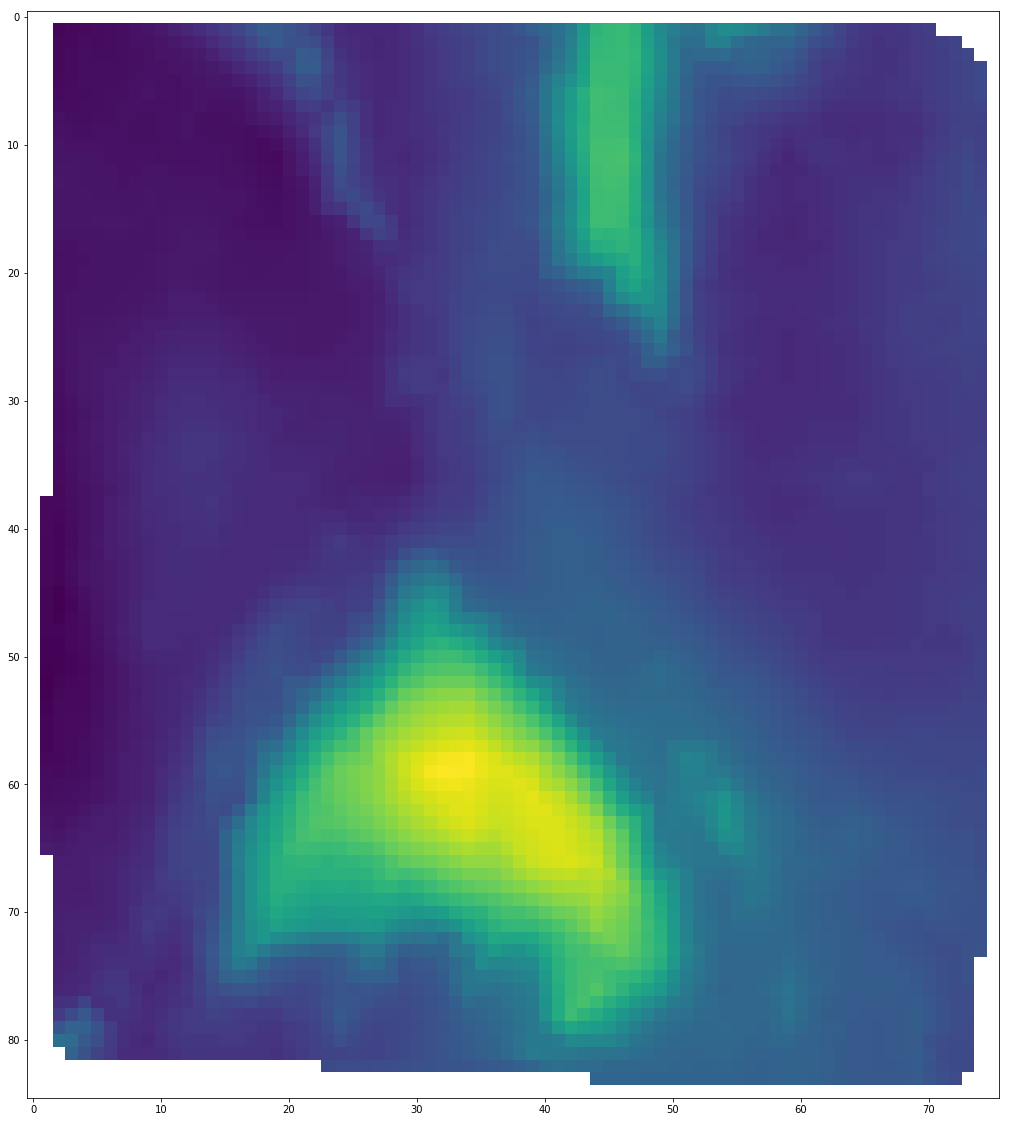

In [17]:
# Reload and replot image from GeoTIFF file as a test
del gdal_dataset
gdal_dataset = gdal.Open('interpolated_grid.tif')
plt.figure(figsize=(30,20))    
plt.imshow(gdal_dataset.GetRasterBand(1).ReadAsArray())
del gdal_dataset